In [1]:
%load_ext autoreload
%autoreload 2

# Analysis 3
This analysis was edited from the opynfield tutorial. Here, we are comparing Canton-S flies with w1118 flies, which have reduced visual acuity. We expect that the w1118 flies will have higher activity as a function of time and coverage than the Canton-S flies, due to their reduced ability to see, and thus learn / habituate to the novel arena boundary.

## 1. Import the package and needed functions / classes

In [2]:
from opynfield.config.user_input import UserInput
from opynfield.config.defaults_settings import Defaults
from opynfield.config.cov_asymptote import CoverageAsymptote
from opynfield.config.model_settings import set_up_fits
from opynfield.config.plot_settings import PlotSettings
from opynfield.readin.run_all import run_all_track_types
from opynfield.calculate_measures.calculate_measures import tracks_to_measures
from opynfield.summarize_measures.summarize_individuals import individual_measures_to_dfs
from opynfield.summarize_measures.summarize_groups import all_group_averages
from opynfield.fit_models.fit_individual_models import fit_all, find_fit_bounds, re_fit_all
from opynfield.fit_models.fit_group_models import group_fit_all
from opynfield.stat_test.stat_test import format_params, format_group_params, run_tests
from opynfield.plotting.plot_individuals import plot_all_individuals, plot_traces
from opynfield.plotting.plot_solo_groups import plot_all_solo_groups
from opynfield.plotting.plot_solo_groups_with_individuals import plot_components_of_solo_groups
from opynfield.plotting.plot_group_comparisons import plot_all_group_comparisons
from opynfield.readin.summary_file import summary_file

from dataclasses import dataclass
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

## 2. Define the settings to use

### 2a. Set up your user inputs

In [3]:
user_settings = UserInput(groups_and_types = {"CantonS": ["Buridian Tracker"], "w1118": ["Buridian Tracker"]},
                          groups_to_paths = {"CantonS": "CS", "w1118": "white"},
                          arena_radius_cm = 4.2,
                          sample_freq = 30,
                          edge_dist_cm = 1,
                          time_bin_size = 1,
                          inactivity_threshold = 0.001,
                          verbose = True,
                          result_path = '/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/Analysis3/ExpectedResultsAnalysis3')

### 2b. Prep the results directory

In [4]:
user_settings.prep_directory()

### 2c. Set up the default settings

In [5]:
default_settings = Defaults()

In [6]:
default_settings.time_averaged_measures = ['activity', 'coverage', 'percent_coverage',
                                            'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                            'p_zero_plus_given_zero', 'p_zero_zero_given_zero']
default_settings.coverage_averaged_measures = ['activity',
                                                'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                                'p_zero_plus_given_zero', 'p_zero_zero_given_zero']

### 2d. Set up the coverage asymptote settings

In [7]:
asymptote_settings = CoverageAsymptote()

### 2e. Set up the model settings

In [8]:
model_settings = set_up_fits()

In [9]:
@dataclass()
class SigmoidDecayModel:
    initial_params: tuple[float, float, float] = (1, -0.1, -10)
    bounds: tuple[tuple[float, float, float], tuple[float, float, float]] = (
        (0, -10, -100),
        (10, 0, 0),
    )
    max_eval: int = 4000
    display_parts: tuple[str] = ("y = ", " / (1 + np.exp(-", " * (x + ", ")))")

    @staticmethod
    def model_function(x, a, b, c):
        # Exponential Implementation
        y = a / (1 + np.exp(-b * (x + c)))
        return y

In [10]:
@dataclass()
class SigmoidIncreaseModel:
    initial_params: tuple[float, float, float] = (1, 0.1, -10)
    bounds: tuple[tuple[float, float, float], tuple[float, float, float]] = (
        (0, 0, -100),
        (10, 10, 0),
    )
    max_eval: int = 4000
    display_parts: tuple[str] = ("y = ", " / (1 + np.exp(-", " * (x + ", ")))")

    @staticmethod
    def model_function(x, a, b, c):
        # Exponential Implementation
        y = a / (1 + np.exp(-b * (x + c)))
        return y

In [11]:
model_settings['percent_coverage']['p_plus_plus_given_plus'].model = SigmoidDecayModel
model_settings['percent_coverage']['p_plus_minus_given_plus'].model = SigmoidIncreaseModel
model_settings['percent_coverage']['p_plus_zero_given_plus'].model = SigmoidIncreaseModel
model_settings['percent_coverage']['p_zero_plus_given_zero'].model = SigmoidDecayModel
model_settings['percent_coverage']['p_zero_zero_given_zero'].model = SigmoidIncreaseModel

### 2f. Set up the plotting settings

In [12]:
plot_settings = PlotSettings(group_colors={'CantonS': 'b', 'w1118': 'r'}, fig_extension='.svg')

## 3. Read in your data

In [13]:
track_list = run_all_track_types(groups_and_types=user_settings.groups_and_types,
                                 verbose=user_settings.verbose,
                                 arena_radius_cm=user_settings.arena_radius_cm,
                                 running_window_length=user_settings.running_window_length,
                                 window_step_size=user_settings.window_step_size,
                                 sample_freq=user_settings.sample_freq,
                                 time_bin_size=user_settings.time_bin_size,
                                 trim=user_settings.trim)

['Buridian Tracker']
{'Buridian Tracker': ['CantonS', 'w1118']}
Read In Buridian Tracker Files For Groups ['CantonS', 'w1118']
Running Buridian Tracker Files For Group: CantonS
CantonS, File 1 Out Of 68
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CantonS, File 2 Out Of 68
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CantonS, File 3 Out Of 68
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CantonS, File 4 Out Of 68
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CantonS, File 5 Out Of 68
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri Track Missing Values Filled
CantonS, File 6 Out Of 68
Buri Units Converted
Buri Units Centered
Buri Track Smoothed
Buri Track Subsampled
Buri

In [14]:
# trim some tracks down to 10min if they went over
for track in track_list:
    if len(track.x) >= 600:
        track.x = track.x[0:600]
        track.y = track.y[0:600]
        track.t = track.t[0:600]

## 4. Calculate behavioral measures

### 4a. Generate the measures

In [15]:
standard_track_list, tracks_by_groups = tracks_to_measures(all_tracks=track_list,
                                                           user_config=user_settings,
                                                           default_settings=default_settings,
                                                           coverage_settings=asymptote_settings)

Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activi

### 4b. Save the measures

In [16]:
individual_dfs = individual_measures_to_dfs(tracks_by_groups=tracks_by_groups,
                                            defaults=default_settings,
                                            user_inputs=user_settings)

Summarizing Tracks From Group CantonS
Summarizing Tracks From Group w1118


### 4c. Calculate group averages of the measures

In [17]:
group_averages = all_group_averages(individual_measures_dfs=individual_dfs,
                                    test_defaults=default_settings,
                                    user_config=user_settings)

Averaging Tracks From Group CantonS by time
Averaging Tracks From Group w1118 by time
Averaging Tracks From Group CantonS By coverage
Averaging Tracks From Group w1118 By coverage
Averaging Tracks From Group CantonS By pica
Averaging Tracks From Group w1118 By pica
Averaging Tracks From Group CantonS By pgca
Averaging Tracks From Group w1118 By pgca
Averaging Tracks From Group CantonS by percent coverage
Averaging Tracks From Group w1118 by percent coverage


We can check out the plots of group averages to check that we specified the correct models.

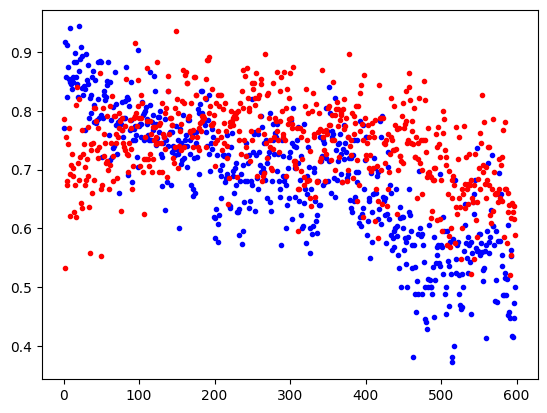

In [18]:
plt.plot(group_averages['time']['CantonS']['p_plus_plus_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['w1118']['p_plus_plus_given_plus'].iloc[0][2:602], 'r.')
plt.show()

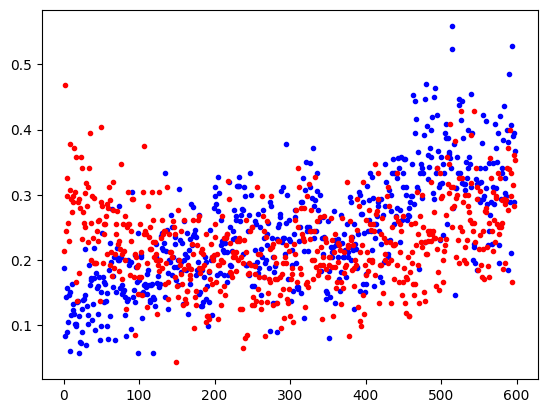

In [19]:
plt.plot(group_averages['time']['CantonS']['p_plus_minus_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['w1118']['p_plus_minus_given_plus'].iloc[0][2:602], 'r.')
plt.show()

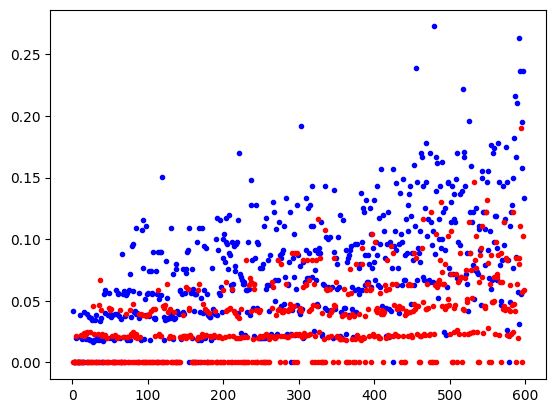

In [20]:
plt.plot(group_averages['time']['CantonS']['p_plus_zero_given_plus'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['w1118']['p_plus_zero_given_plus'].iloc[0][2:602], 'r.')
plt.show()

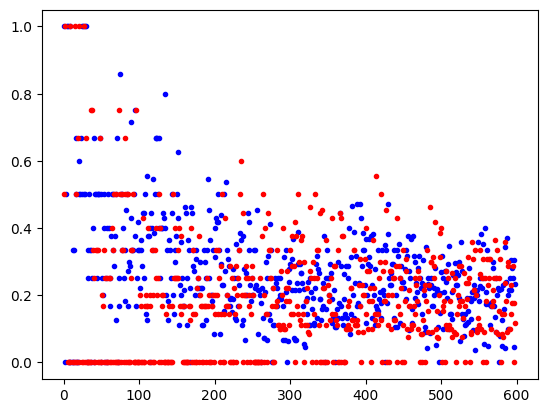

In [21]:
plt.plot(group_averages['time']['CantonS']['p_zero_plus_given_zero'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['w1118']['p_zero_plus_given_zero'].iloc[0][2:602], 'r.')
plt.show()

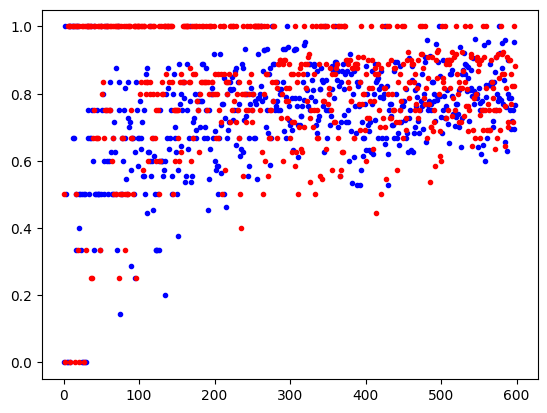

In [22]:
plt.plot(group_averages['time']['CantonS']['p_zero_zero_given_zero'].iloc[0][2:602], 'b.')
plt.plot(group_averages['time']['w1118']['p_zero_zero_given_zero'].iloc[0][2:602], 'r.')
plt.show()

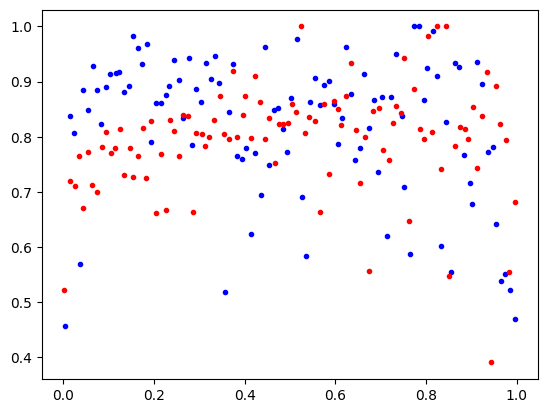

In [23]:
plt.plot(group_averages['percent_coverage']['CantonS']['percent_coverage mean'],
         group_averages['percent_coverage']['CantonS']['p_plus_plus_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['w1118']['percent_coverage mean'],
         group_averages['percent_coverage']['w1118']['p_plus_plus_given_plus mean'], 'r.')
plt.show()

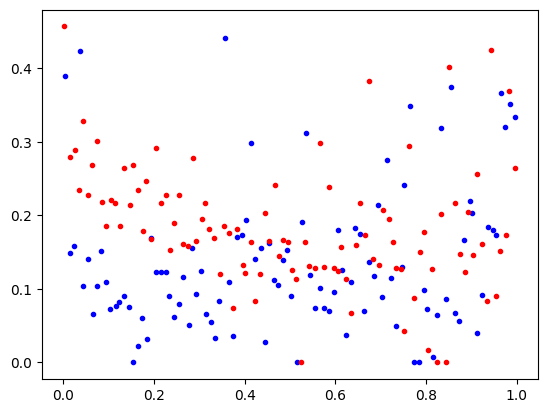

In [24]:
plt.plot(group_averages['percent_coverage']['CantonS']['percent_coverage mean'],
         group_averages['percent_coverage']['CantonS']['p_plus_minus_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['w1118']['percent_coverage mean'],
         group_averages['percent_coverage']['w1118']['p_plus_minus_given_plus mean'], 'r.')
plt.show()

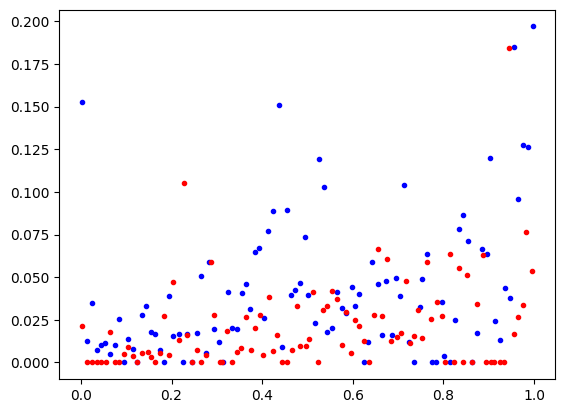

In [25]:
plt.plot(group_averages['percent_coverage']['CantonS']['percent_coverage mean'],
         group_averages['percent_coverage']['CantonS']['p_plus_zero_given_plus mean'], 'b.')
plt.plot(group_averages['percent_coverage']['w1118']['percent_coverage mean'],
         group_averages['percent_coverage']['w1118']['p_plus_zero_given_plus mean'], 'r.')
plt.show()

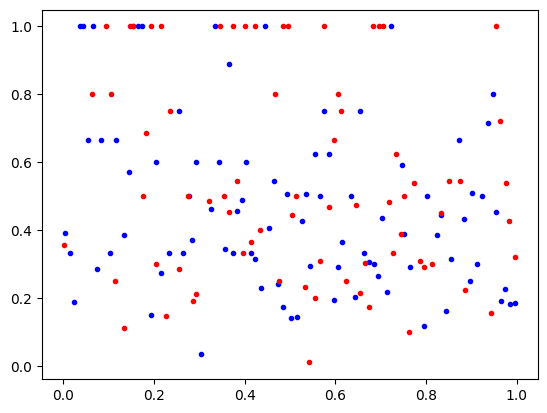

In [26]:
plt.plot(group_averages['percent_coverage']['CantonS']['percent_coverage mean'],
         group_averages['percent_coverage']['CantonS']['p_zero_plus_given_zero mean'], 'b.')
plt.plot(group_averages['percent_coverage']['w1118']['percent_coverage mean'],
         group_averages['percent_coverage']['w1118']['p_zero_plus_given_zero mean'], 'r.')
plt.show()

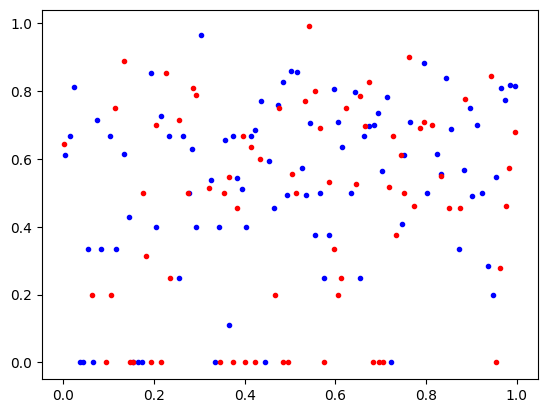

In [27]:
plt.plot(group_averages['percent_coverage']['CantonS']['percent_coverage mean'],
         group_averages['percent_coverage']['CantonS']['p_zero_zero_given_zero mean'], 'b.')
plt.plot(group_averages['percent_coverage']['w1118']['percent_coverage mean'],
         group_averages['percent_coverage']['w1118']['p_zero_zero_given_zero mean'], 'r.')
plt.show()

## 5. Fit models to individuals' measures

### 5a. Naive bounds

In [28]:
naive_fits = fit_all(individual_measures_dfs=individual_dfs,
                     defaults=default_settings,
                     model_params=model_settings)

Fitting Models To Tracks From Group CantonS by time
Fitting Models To Tracks From Group CantonS by coverage
Fitting Models To Tracks From Group CantonS by pica
Fitting Models To Tracks From Group CantonS by pgca
Fitting Models To Tracks From Group CantonS by percent_coverage
Fitting Models To Tracks From Group w1118 by time
Fitting Models To Tracks From Group w1118 by coverage
Fitting Models To Tracks From Group w1118 by pica
Fitting Models To Tracks From Group w1118 by pgca
Fitting Models To Tracks From Group w1118 by percent_coverage


### 5b. Find new bounds

In [29]:
upper_bounds, lower_bounds, p0s = find_fit_bounds(fits=naive_fits,
                                                  user_inputs=user_settings)

### 5c. Re-fit models

In [30]:
bounded_fits = re_fit_all(individual_measures_dfs=individual_dfs,
                          defaults=default_settings,
                          model_params=model_settings,
                          upper=upper_bounds,
                          lower=lower_bounds,
                          initial=p0s )

Re-Fitting Models To Tracks From Group CantonS by time
Re-Fitting Models To Tracks From Group CantonS by coverage
Re-Fitting Models To Tracks From Group CantonS by pica
Re-Fitting Models To Tracks From Group CantonS by pgca
Re-Fitting Models To Tracks From Group CantonS by percent_coverage
Re-Fitting Models To Tracks From Group w1118 by time
Re-Fitting Models To Tracks From Group w1118 by coverage
Re-Fitting Models To Tracks From Group w1118 by pica
Re-Fitting Models To Tracks From Group w1118 by pgca
Re-Fitting Models To Tracks From Group w1118 by percent_coverage


### 5d. Format and save the bounded individual fits

In [31]:
formatted_bounded_fits = format_params(bounded_fits=deepcopy(bounded_fits),
                                       defaults=default_settings,
                                       user_inputs=user_settings)

## 6. Fit models to group measures

### 6a. Fit the group models with bounds

In [32]:
group_fits = group_fit_all(individual_measures_dfs=individual_dfs,
                           defaults=default_settings,
                           model_params=model_settings,
                           upper=upper_bounds,
                           lower=lower_bounds,
                           initial=p0s)

Fitting Models To Entire Group CantonS by time
Fitting Models To Entire Group CantonS by coverage
Fitting Models To Entire Group CantonS by pica
Fitting Models To Entire Group CantonS by pgca
Fitting Models To Entire Group CantonS by percent_coverage
Fitting Models To Entire Group w1118 by time
Fitting Models To Entire Group w1118 by coverage
Fitting Models To Entire Group w1118 by pica
Fitting Models To Entire Group w1118 by pgca
Fitting Models To Entire Group w1118 by percent_coverage


### 6b. Format and save the bounded group fits

In [33]:
format_group_params(group_fits=deepcopy(group_fits),
                    defaults=default_settings,
                    user_inputs=user_settings)

## 7. Run statistical tests

In [34]:
run_tests(formatted_bounded_fits=formatted_bounded_fits,
          defaults=default_settings,
          user_inputs=user_settings)

## 8. Plot the results

### 8a. Plot individuals

In [35]:
plot_all_individuals(measures=individual_dfs,
                     model_params=bounded_fits,
                     model_info=model_settings,
                     defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Individuals From Group CantonS by time
Plotting Individuals From Group CantonS by coverage
Plotting Individuals From Group CantonS by pica
Plotting Individuals From Group CantonS by pgca
Plotting Individuals From Group CantonS by percent_coverage
Plotting Individuals From Group w1118 by time
Plotting Individuals From Group w1118 by coverage
Plotting Individuals From Group w1118 by pica
Plotting Individuals From Group w1118 by pgca
Plotting Individuals From Group w1118 by percent_coverage


### 8b. Plot traces

In [36]:
plot_traces(tracks_by_groups=tracks_by_groups,
            plot_settings=plot_settings,
            user_input=user_settings)

### 8c. Plot group averages

In [37]:
plot_all_solo_groups(group_averages=group_averages,
                     group_fits=group_fits,
                     model_params=model_settings,
                     test_defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Group CantonS by time
Plotting Group CantonS by coverage
Plotting Group CantonS by pica
Plotting Group CantonS by pgca
Plotting Group CantonS by percent_coverage
Plotting Group w1118 by time
Plotting Group w1118 by coverage
Plotting Group w1118 by pica
Plotting Group w1118 by pgca
Plotting Group w1118 by percent_coverage


### 8d. Plot group averages with component individuals

In [38]:
plot_components_of_solo_groups(individuals=individual_dfs,
                               individual_fits=bounded_fits,
                               groups=group_averages,
                               group_fits=group_fits,
                               model_specs=model_settings,
                               defaults=default_settings,
                               plot_settings=plot_settings,
                               user_inputs=user_settings)

Plotting Group And Individuals of CantonS by time
Plotting Group And Individuals of CantonS by coverage
Plotting Group And Individuals of CantonS by pica
Plotting Group And Individuals of CantonS by pgca
Plotting Group And Individuals of CantonS by percent_coverage
Plotting Group And Individuals of w1118 by time
Plotting Group And Individuals of w1118 by coverage
Plotting Group And Individuals of w1118 by pica
Plotting Group And Individuals of w1118 by pgca
Plotting Group And Individuals of w1118 by percent_coverage


### 8e. Plot group average comparisons

In [39]:
plot_all_group_comparisons(group_averages=group_averages,
                           group_fits=group_fits,
                           model_params=model_settings,
                           test_defaults=default_settings,
                           plot_settings=plot_settings,
                           user_config=user_settings)

Plotting Group Comparisons by time
Plotting Group Comparisons by coverage
Plotting Group Comparisons by pica
Plotting Group Comparisons by pgca
Plotting Group Comparisons by percent_coverage


## 9. Summarize the run

In [40]:
summary_file(tracks_by_group=tracks_by_groups,
             test_cov_asymptote=asymptote_settings,
             user_defaults=default_settings,
             model_settings=model_settings,
             plot_settings=plot_settings,
             user_config=user_settings)

Formatting Summary File


## You're done!